In [1]:
import tensorflow as tf
import numpy as np
from scipy.misc import imread, imresize
import os
import math

C:\Users\parke\Anaconda2\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
width, height = 170,170
files = os.listdir('positive_hand')

images = [imread('positive_hand/'+i) for i in files[:10000]]
resized = [imresize(i, (width, height)) for i in images]
images = np.array(resized)

C:\Users\parke\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
C:\Users\parke\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [3]:
#save RAM

del resized

In [4]:
np.shape(images)

(10000, 170, 170, 3)

In [5]:
poslabels = np.ones(10000)

In [6]:

files = os.listdir('new_neg_data')

negimages = [imread('new_neg_data/'+i) for i in files[:10000]]
negresized = [imresize(i, (width, height)) for i in negimages]
negimages = np.array(negresized)

C:\Users\parke\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
C:\Users\parke\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [7]:

del negresized

In [8]:
np.shape(negimages)

(10000, 170, 170, 3)

In [9]:
neglabels = np.zeros(10000)

In [10]:
np.shape(np.append(images, negimages,axis = 0))

(20000, 170, 170, 3)

In [11]:
xData = np.append(images, negimages,axis = 0)

yData = np.append(poslabels,neglabels,axis = 0)

In [12]:
p = np.random.permutation(20000)
xData = xData[p]
yData = yData[p]


In [13]:
X_train = xData[:15000]
X_val = xData[15000:]

y_train = yData[:15000]
y_val = yData[15000:]

In [14]:
np.shape(yData)

(20000,)

In [15]:
np.shape(y_train)

(15000,)

In [16]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 170, 170, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

In [17]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [31]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 170, 170, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
def my_model(X,y,is_training):
    # define our weights (e.g. init_two_layer_convnet)
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[9, 9, 3, 64],initializer = tf.truncated_normal_initializer(stddev=5e-2))
    bconv1 = tf.get_variable("bconv1", shape=[64], initializer = tf.constant_initializer(0.0))
    
    Wconv2 = tf.get_variable("Wconv2", shape=[6, 6, 64, 128],initializer = tf.truncated_normal_initializer(stddev=5e-2))
    bconv2 = tf.get_variable("bconv2", shape=[128], initializer = tf.constant_initializer(0.1))
    
    Wconv3 = tf.get_variable("Wconv3", shape=[3, 3, 128, 256],initializer = tf.truncated_normal_initializer(stddev=5e-2))
    bconv3 = tf.get_variable("bconv3", shape=[256], initializer = tf.constant_initializer(0.1))
    
    Wconv4 = tf.get_variable("Wconv4", shape=[3, 3, 256, 512],initializer = tf.truncated_normal_initializer(stddev=5e-2))
    bconv4 = tf.get_variable("bconv4", shape=[512], initializer = tf.constant_initializer(0.1))
    

    
    W1 = tf.get_variable("W1", shape=[51200, 128],initializer = tf.truncated_normal_initializer(stddev=4e-2))
    b1 = tf.get_variable("b1", shape=[128], initializer = tf.constant_initializer(0.1))
    W2 = tf.get_variable("W2", shape=[128, 64],initializer = tf.truncated_normal_initializer(stddev=4e-2))
    b2 = tf.get_variable("b2", shape=[64], initializer = tf.constant_initializer(0.1))
    W3 = tf.get_variable("W3", shape=[64, 2],initializer = tf.truncated_normal_initializer(stddev=5e-3))
    b3 = tf.get_variable("b3", shape=[2], initializer = tf.constant_initializer(0.0))
    
    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides = [1 ,1 ,1, 1], padding='SAME') + bconv1
    h1 = tf.nn.relu(a1)
    pooled1 = tf.layers.max_pooling2d(inputs=h1, pool_size=[2,2], strides=2)
    norm1 = tf.nn.lrn(pooled1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm1')
  
    a2 = tf.nn.conv2d(norm1, Wconv2, strides = [1 ,1 ,1, 1], padding='SAME') + bconv2
    h2 = tf.nn.relu(a2)
    pooled2 = tf.layers.max_pooling2d(inputs=h2, pool_size=[2,2], strides=2)
    norm2 = tf.nn.lrn(pooled2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm2')
   

    
    a3 = tf.nn.conv2d(norm2, Wconv3, strides = [1 ,1 ,1, 1], padding='SAME') + bconv3
    h3 = tf.nn.relu(a3)
    pooled3 = tf.layers.max_pooling2d(inputs=h3, pool_size=[2,2], strides=2)
    norm3 = tf.nn.lrn(pooled3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm3')
    
    a4 = tf.nn.conv2d(norm3, Wconv4, strides = [1 ,1 ,1, 1], padding='SAME') + bconv4
    h4 = tf.nn.relu(a4)
    pooled4 = tf.layers.max_pooling2d(inputs=h4, pool_size=[2,2], strides=2)
    norm4 = tf.nn.lrn(pooled4, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm4')
    print(np.shape(norm4))
    h1_flat = tf.reshape(norm4,[-1,51200])
    h2_dropped = tf.layers.dropout(h1_flat,0.5,training= is_training)
    h2_in = tf.matmul(h2_dropped,W1) + b1
    h2_inactd = tf.nn.relu(h2_in)
    
    h3_in = tf.matmul(h2_inactd,W2) + b2
    h3_inactd = tf.nn.relu(h3_in)
    
    
    y_out = tf.matmul(h3_inactd,W3) + b3
    return y_out





y_out = my_model(X,y,is_training)
# define our loss
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,2),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(0.0005) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)




# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

(?, 10, 10, 512)


In [32]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,3,128,5000,train_step,False)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,3,128,5000,train_step,False)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,3,128,5000,train_step,False)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,3,128,5000,train_step,False)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,3,128,5000,train_step,False)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,3,128,5000,train_step,False)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,3,128,5000,train_step,False)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,3,128,5000,train_step,False)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Iteration 0: with minibatch training loss = 0.814 and accuracy of 0.48
Epoch 1, Overall loss = 0.228 and accuracy of 0.899


KeyboardInterrupt: 

In [51]:
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)


Epoch 1, Overall loss = 0.0221 and accuracy of 0.994


(0.02207093615923077, 0.9942)

In [35]:
import cv2
import matplotlib.pyplot as plt

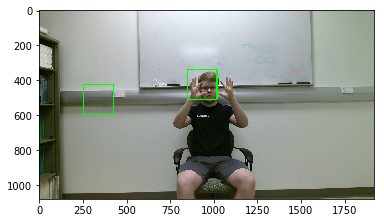

In [56]:
# Please define the name of the image you want to detect hand here
# If the file is located inside another folder, Please specify the
# path to the file as well,
# ex: if the file is name a.jpg and is within folder file, please
#     specify the name_of_file = 'file/a.jpg'
name_of_file = 'demo_images/000_1751.jpg'
 
 
# look for the name of the file
toPredict = cv2.imread(name_of_file)
 
# show the image
plt.figure()
# openCV uses a different color scheme, change it back to RGB for plotting
RGB_img = cv2.cvtColor(toPredict, cv2.COLOR_BGR2RGB)
 
# Using the sliding window approach to predict the location of hands
# sliding window with same stride of 170 (same as creating a grid!)
dimension = toPredict.shape
endCol = dimension[1]-170 # the last column
endRow = dimension[0]-170 # the last row
 
locations = []
 
model_input = [] 
 
for row in range(0,endRow-170,85):
    for col in range(0,endCol-170,85):
        crop_img = toPredict[ row :row+170  , col : col+170] 

        model_input.append(crop_img)

        locations.append((row,col))


    
scores = y_out.eval(feed_dict = {X:np.array(model_input),y:np.array([0 for n in range(np.shape(model_input)[0])]),is_training:False},session = sess)
    
try:    
    top_2_indexes = sorted(range(len(scores)), key=lambda i: scores[i][1])[:2]   
except:
    print('not enough hands were recognized')
    
for i in top_2_indexes:
    cv2.rectangle(RGB_img, (locations[i][1], locations[i][0]), (locations[i][1]+170, locations[i][0]+170), (0,255,0),  thickness=5)

    
    

     
plt.imshow(RGB_img)
plt.show()
